In [16]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

if os.path.join(os.path.dirname(os.getcwd()), "controller") not in sys.path:
    sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "controller"))

from nhl_data_loader import NHLDataLoader

loader = NHLDataLoader()


In [17]:
train_val_df = loader.load_csv_files([2016,2017,2018,2019])
print(train_val_df.head())

      game_id   game_date  home_team_id  period time_in_period  event_id  \
0  2016020001  2016-10-12             9       1          00:00         5   
1  2016020001  2016-10-12             9       1          00:00         6   
2  2016020001  2016-10-12             9       1          00:05        51   
3  2016020001  2016-10-12             9       1          00:05         7   
4  2016020001  2016-10-12             9       1          00:43       201   

     event_type  is_goal shot_type  x_coord  ...  last_x_coord  last_y_coord  \
0  period-start    False   Unknown      NaN  ...       unknown       unknown   
1       faceoff    False   Unknown      0.0  ...       unknown       unknown   
2      stoppage    False   Unknown      NaN  ...       unknown       unknown   
3       faceoff    False   Unknown     69.0  ...       unknown       unknown   
4      takeaway    False   Unknown    -81.0  ...       unknown       unknown   

  time_since_last_event distance_from_last_event  rebound  \
0

In [18]:
test_df = loader.load_csv_files([2020])
print(test_df.head())

      game_id   game_date  home_team_id  period time_in_period  event_id  \
0  2020020001  2021-01-13             4       1          00:00        51   
1  2020020001  2021-01-13             4       1          00:00        52   
2  2020020001  2021-01-13             4       1          00:16        53   
3  2020020001  2021-01-13             4       1          00:23         8   
4  2020020001  2021-01-13             4       1          00:28        54   

     event_type  is_goal shot_type  x_coord  ...  last_x_coord  last_y_coord  \
0  period-start    False   Unknown      NaN  ...       unknown       unknown   
1       faceoff    False   Unknown      0.0  ...       unknown       unknown   
2  shot-on-goal    False     wrist    -74.0  ...           0.0           0.0   
3      takeaway    False   Unknown    -39.0  ...       unknown       unknown   
4  blocked-shot    False   Unknown    -58.0  ...       unknown       unknown   

  time_since_last_event distance_from_last_event  rebound  \
0

In [19]:
columns = [
    'shooting_distance', 'shot_angle', 'is_goal', 'x_coord', 'y_coord',
    'speed_from_last_event', 'rebound', 'strength_status',
    'rebound_angle', 'distance_from_last_event'
]

df_train = train_val_df[columns]
df_test = test_df[columns]

In [20]:
# Nettoyage : suppression des valeurs manquantes et conversion des types
df_train = df_train.dropna()
df_test = df_test.dropna()

df_train['is_goal'] = df_train['is_goal'].astype(int)
df_train['rebound'] = df_train['rebound'].astype(int)
df_test['is_goal'] = df_test['is_goal'].astype(int)
df_test['rebound'] = df_test['rebound'].astype(int)

print(f"Données d'entraînement : {df_train.shape[0]} lignes, {df_train.shape[1]} colonnes")
print(f"Données de test : {df_test.shape[0]} lignes, {df_test.shape[1]} colonnes")

Données d'entraînement : 61404 lignes, 10 colonnes
Données de test : 11503 lignes, 10 colonnes


In [21]:
# Variables X (caractéristiques) et y (cible)
X_train = df_train.drop(columns=['is_goal'])
y_train = df_train['is_goal']
X_test = df_test.drop(columns=['is_goal'])
y_test = df_test['is_goal']

In [22]:
# Colonnes catégoriques à encoder
categorical_columns = ['strength_status']

# Encodage one-hot
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include='bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(include='bool').columns})

print(X_train.dtypes)
print(X_test.dtypes)


shooting_distance               float64
shot_angle                      float64
x_coord                         float64
y_coord                         float64
speed_from_last_event           float64
rebound                           int32
rebound_angle                   float64
distance_from_last_event        float64
strength_status_Penalty Kill      int32
strength_status_Power Play        int32
dtype: object
shooting_distance               float64
shot_angle                      float64
x_coord                         float64
y_coord                         float64
speed_from_last_event           float64
rebound                           int32
rebound_angle                   float64
distance_from_last_event        float64
strength_status_Penalty Kill      int32
strength_status_Power Play        int32
dtype: object


In [23]:
# Remplacer les valeurs infinies par NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

print("Vérification des données nettoyées :")
print(X_train.isna().sum())
print(X_test.isna().sum())


Vérification des données nettoyées :
shooting_distance               0
shot_angle                      0
x_coord                         0
y_coord                         0
speed_from_last_event           0
rebound                         0
rebound_angle                   0
distance_from_last_event        0
strength_status_Penalty Kill    0
strength_status_Power Play      0
dtype: int64
shooting_distance               0
shot_angle                      0
x_coord                         0
y_coord                         0
speed_from_last_event           0
rebound                         0
rebound_angle                   0
distance_from_last_event        0
strength_status_Penalty Kill    0
strength_status_Power Play      0
dtype: int64


In [24]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (61404, 10)
y_train shape: (61404,)
X_test shape: (11503, 10)
y_test shape: (11503,)


In [25]:
# Identifier et supprimer les colonnes constantes
constant_columns = [col for col in X_train.columns if X_train[col].nunique() == 1]
print(f"Colonnes constantes : {constant_columns}")
X_train.drop(columns=constant_columns, inplace=True)
X_test.drop(columns=constant_columns, inplace=True)

# Vérifier et remplacer les NaN restants
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

Colonnes constantes : ['rebound']


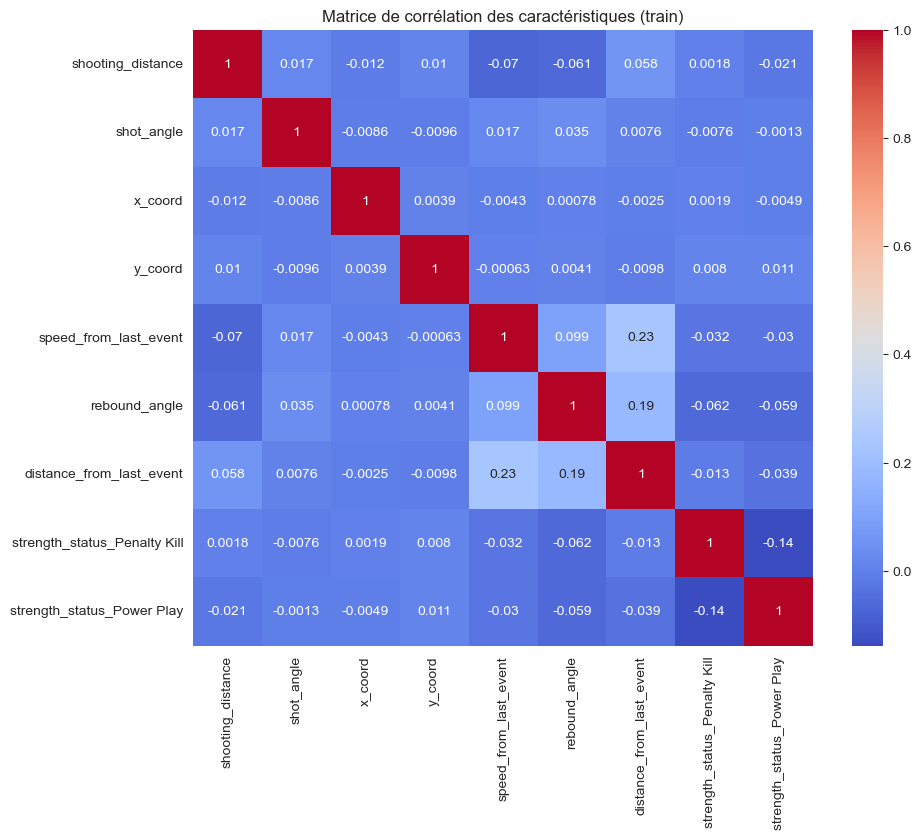

Caractéristiques sélectionnées avec SelectKBest : ['shooting_distance', 'speed_from_last_event', 'rebound_angle', 'strength_status_Penalty Kill', 'strength_status_Power Play']


In [26]:
#Sélection de caractéristiques
# (a) Matrice de corrélation (données d'entraînement uniquement)
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation des caractéristiques (train)")
plt.show()

# (b) Sélection avec SelectKBest
k = 5  # Nombre de caractéristiques à sélectionner
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X_train.columns[selector.get_support()]
print(f"Caractéristiques sélectionnées avec SelectKBest : {list(selected_features)}")

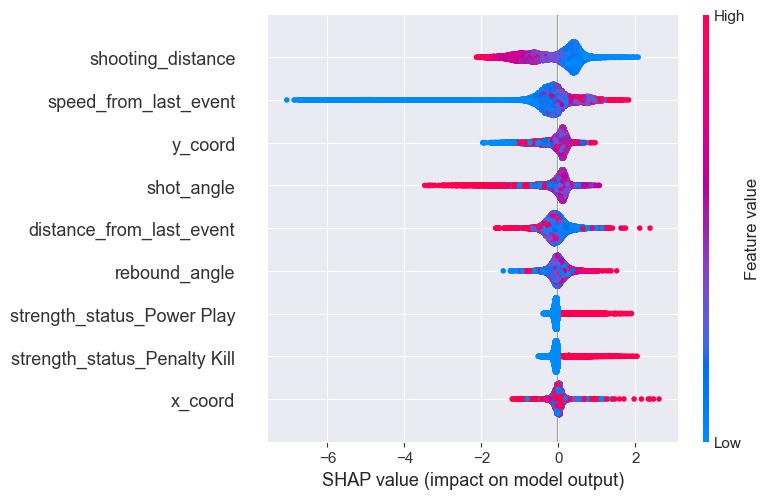

In [27]:
# Modèle XGBoost
model_shap = xgb.XGBClassifier(eval_metric='logloss')
model_shap.fit(X_train, y_train)

# Calcul des valeurs SHAP
explainer = shap.Explainer(model_shap)
shap_values = explainer(X_train)

# Diagramme SHAP summary
shap.summary_plot(shap_values, X_train)


In [29]:
# (a) Modèle avec toutes les caractéristiques
model_all = xgb.XGBClassifier(eval_metric='logloss')
model_all.fit(X_train, y_train)
y_pred_all = model_all.predict_proba(X_test)[:, 1]
auc_all = roc_auc_score(y_test, y_pred_all)
print(f"AUC avec toutes les caractéristiques : {auc_all}")

# (b) Modèle avec caractéristiques sélectionnées
model_selected = xgb.XGBClassifier(eval_metric='logloss')
model_selected.fit(X_train[selected_features], y_train)
y_pred_selected = model_selected.predict_proba(X_test[selected_features])[:, 1]
auc_selected = roc_auc_score(y_test, y_pred_selected)
print(f"AUC avec caractéristiques sélectionnées : {auc_selected}")

# (c) Modèle avec caractéristique simple
baseline_model = xgb.XGBClassifier(eval_metric='logloss')
baseline_model.fit(X_train[['shooting_distance']], y_train)
y_pred_baseline = baseline_model.predict_proba(X_test[['shooting_distance']])[:, 1]
auc_baseline = roc_auc_score(y_test, y_pred_baseline)
print(f"AUC du modèle baseline (distance uniquement) : {auc_baseline}")



AUC avec toutes les caractéristiques : 0.7031531255546595
AUC avec caractéristiques sélectionnées : 0.6761051972078154
AUC du modèle baseline (distance uniquement) : 0.6678145806234381


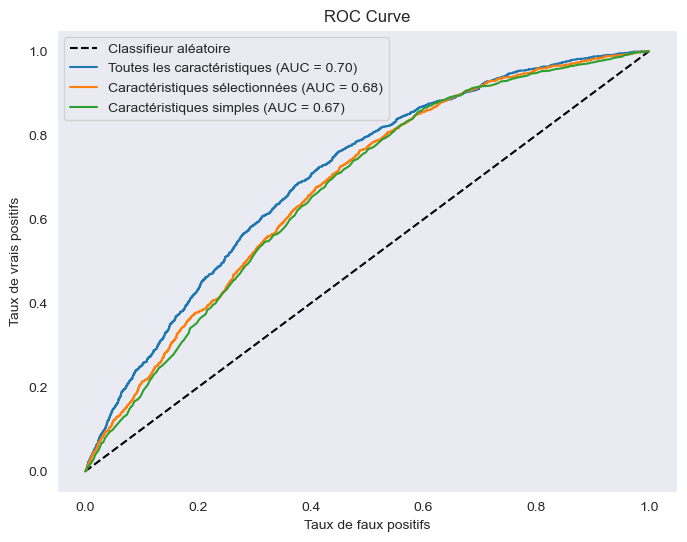

In [35]:
from sklearn.metrics import roc_curve

def plot_roc(y_true, y_pred, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_score(y_true, y_pred):.2f})")
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label="Classifieur aléatoire")
plot_roc(y_test, y_pred_all, "Toutes les caractéristiques")
plot_roc(y_test, y_pred_selected, "Caractéristiques sélectionnées")
plot_roc(y_test, y_pred_baseline, "Caractéristiques simples")
plt.show()